In [1]:
import sys
sys.path.append("YOUR/PATH/TO/ROOT/DIRECTORY")
import time

import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import torch

from src.learn_kernel import LearningKernel
from src.pipeline_mimic import feature_selection, get_train_test_action_pred

## Preprocessing

This is just data loading. Primary changes are to convert the data to use the TEST set rather than the train set.

In [3]:
data_path = "YOUR/PATH/TO/DATA"

states = pickle.load(open(data_path + 'states_modified_1hr.p','rb'))
actions = pickle.load(open(data_path + 'actions_discretized_vaso5_fluid4_1hr.p','rb'))
rewards = pickle.load(open(data_path + 'rewards_1hr.p','rb'))

In [114]:
pid = list(states.keys())
X_train_ori, X_test_ori, X_next_train_ori, X_next_test_ori, y_train, y_test, \
R_train, R_test, train_pid, test_pid, train_hr, test_hr, \
train_map_below65_indices, test_map_below65_indices = \
get_train_test_action_pred(pid, states, actions, rewards, original=False, 
                           include_action_states=True, transform=False)
columns = states[pid[0]].columns.append(actions[pid[0]].columns[1:7])
multi_feat_indices = pickle.load(open('../results/intermediate/selected_feature_indices.p', 'rb'))
column_names = columns[multi_feat_indices]

In [123]:
a_test = np.load(path1 + 'A_test.npy')
X_test = np.load(path1 + 'S1_test.npy')
s1_test = X_test[test_map_below65_indices]
X_train = np.load(path1 + 'S1_train.npy')
s1_train = X_train[train_map_below65_indices]

In [116]:
from collections import Counter

Counter(y_test), Counter(a_test)

(Counter({0: 154705, 2: 21970, 1: 5500, 3: 3496}),
 Counter({0: 154705, 2: 21970, 1: 5500, 3: 3496}))

In [103]:
kernel_dict = torch.load('../results/model//multi_withindics_interpret_kernel_setseed888')

torch.manual_seed(888)
kernel = LearningKernel(s1_test.shape[1], 4, 500, interpret=True)
kernel.load_state_dict(kernel_dict)

<All keys matched successfully>

In [104]:
def onehot_actions(A):
    # convert A to one-hot matrix
    num_actions = len(np.unique(A))
    onehot = np.zeros((len(A), num_actions))
    onehot[np.arange(len(A)), A] = 1
    return onehot

In [105]:
z1_test = kernel.trans_to_rff(s1_test)
onehot_test = onehot_actions(a_test)[test_map_below65_indices]

## Distance Exploration

Below, to get a general sense of the distance distribution, we sample 5000 random points and compute the pairwise distances. We then plot a histogram. It appears the distribution is quite strongly skewed right. 

In [107]:
seed = 888
samplesize = 5000

np.random.seed(seed)
sample_idx = np.random.choice(range(len(z1_test)), samplesize, replace=False)
z = z1_test[sample_idx]

distancelist = np.matrix.flatten(np.matmul(z, z.T))    

(array([5.546000e+03, 2.462060e+05, 1.941396e+06, 6.566484e+06,
        6.950700e+06, 4.404884e+06, 8.711240e+05, 5.469200e+04,
        3.935000e+04, 4.174400e+04, 3.956000e+04, 3.827800e+04,
        5.020800e+04, 5.547600e+04, 7.074400e+04, 9.957600e+04,
        1.485480e+05, 2.486720e+05, 3.963420e+05, 4.452160e+05,
        2.221140e+05, 8.132600e+04, 1.111540e+05, 1.645860e+05,
        2.535840e+05, 4.315300e+05, 5.222250e+05, 4.671280e+05,
        2.641400e+04, 5.193000e+03]),
 array([-1.6873531e-01, -1.2649515e-01, -8.4254980e-02, -4.2014819e-02,
         2.2534629e-04,  4.2465512e-02,  8.4705673e-02,  1.2694584e-01,
         1.6918600e-01,  2.1142617e-01,  2.5366634e-01,  2.9590648e-01,
         3.3814666e-01,  3.8038683e-01,  4.2262700e-01,  4.6486714e-01,
         5.0710732e-01,  5.4934746e-01,  5.9158766e-01,  6.3382781e-01,
         6.7606795e-01,  7.1830815e-01,  7.6054829e-01,  8.0278844e-01,
         8.4502864e-01,  8.8726878e-01,  9.2950898e-01,  9.7174913e-01,
         1

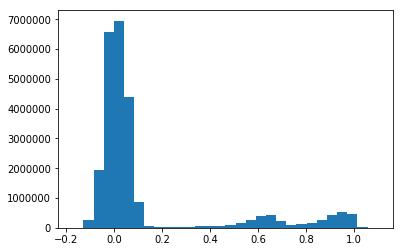

In [19]:
plt.hist(distancelist, bins=30)

The code below performs the action prediction based on neighbors.

In [118]:
def test_radius(Z1, A, r, seed=888, samplesize=1e4, batchsize=1000):
    '''Estimate the points radius in learned kernel space'''
    
    # transform to z-space and draw sample
    np.random.seed(seed)
    sample_idx = np.random.choice(range(len(Z1)), samplesize, replace=False)
    z = Z1[sample_idx]
    a = A[sample_idx]
    avg_a = np.mean(a, axis=0)
    
    # predict actions by averaging neighbor votes
    num_batches = samplesize // batchsize
    num_actions = A.shape[1]
    a_hat_ls = []
    
    for i in range(num_batches + 1):
        t0 = time.time()
        batch_z = z[i * batchsize:min((i + 1) * batchsize, samplesize)]
        batch_neighbors = np.matmul(batch_z, z.T) > r
        a_hat_ls.append(np.matmul(batch_neighbors, a))
        t1 = time.time()
    a_hat = np.vstack(a_hat_ls)

    # remove self from count
    self_count = (np.sum(np.square(z), axis=1, keepdims=True) > r) * a
    a_hat = a_hat - self_count
    
    # normalize over rows, setting 0s to dataset average
    a_hat[np.sum(a_hat, axis=1) == 0] = avg_a
    a_hat = a_hat / np.sum(a_hat, axis=1, keepdims=True)
    
    # return accuracy, auc, and cross-entropy loss
    acc = accuracy_score(np.argmax(a, axis=1), np.argmax(a_hat, axis=1))
    auc = multiclass_roc_auc_score(np.argmax(a, axis=1), np.argmax(a_hat, axis=1))
    cel = log_loss(a, a_hat) # unweighted 
    
    return acc, auc, cel

## Testing

In this section, we run the above code for a large range of `r` values, different seeds (but same across each r), sample size 20,000 and batch size 5,000.

In [26]:
result_ls = []
r_ls = []

# for r in [0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
for r in [0.55, 0.65, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print(r)
    r_ls.append(r)
    for seed in [1, 2, 3, 4, 5]:
        t0 = time.time()
        result_ls.append(test_radius(z1_test, onehot_test, r, seed=seed, 
                                     samplesize=20000, batchsize=5000))
        print(result_ls[-1])
        t1 = time.time()

0.55
(0.8821, 0.7388199396103585, 0.7311434585914937)
(0.8814, 0.7343841020149935, 0.7173904616793367)
(0.87795, 0.7233920596304504, 0.7426766541177814)
(0.88365, 0.7279924624051337, 0.7178705090392936)
(0.8794, 0.729719952390307, 0.6835177342425311)
0.65
(0.8823, 0.744433711716098, 0.8364263777842461)
(0.88215, 0.7406377515421194, 0.8026854448818748)
(0.8796, 0.7319004136372914, 0.834381527828988)
(0.8835, 0.7331617396006813, 0.7982847389166892)
(0.8813, 0.7350354659484446, 0.7711039593904215)
0.75
(0.88425, 0.7508311731408761, 0.8992417611248628)
(0.88355, 0.7483844540264718, 0.8983785788848765)
(0.8807, 0.7362876811756737, 0.9072313768117399)
(0.88345, 0.7351770029116594, 0.8700224554303017)
(0.88215, 0.7408030525609968, 0.8693825285257372)
0.8
(0.88415, 0.7539574287545594, 0.9553612501147903)
(0.8843, 0.7546435617991407, 0.9731516619004579)
(0.882, 0.743629681931869, 0.9596357413649286)
(0.8838, 0.7380464175815742, 0.9399227897613369)
(0.883, 0.7449605500542504, 0.9602868500739536)

In [121]:
metric_means = []
metric_sds = []

for m in range(3):
    metric_means.append([])
    metric_sds.append([])
    for i in range(len(r_ls)):
        metrics = np.array([x[m] for x in result_ls[5 * i : 5 * (i+1)]])
        metric_means[-1].append(np.mean(metrics))
        metric_sds[-1].append(np.std(metrics))

## Results

This plot shows the results for each of the metrics (accuracy, auc, and cross-entropy loss).

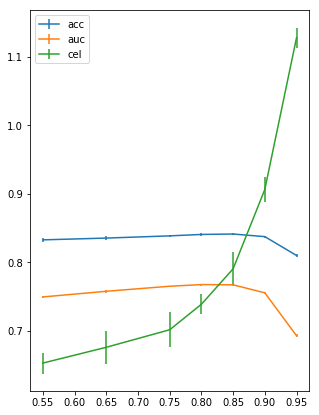

In [122]:
plt.figure(figsize=(5, 7))
order = np.argsort(np.array(r_ls))
metric_names = ['acc', 'auc', 'cel']
for m in range(3):
    plt.errorbar(np.array(r_ls)[order], np.array(metric_means[m])[order], 
                 yerr=np.array(metric_sds[m])[order],
             label=metric_names[m])
plt.legend()

## Conclusions

From the AUC and ACC, an r around 0.85 seems to be best. This is surprisingly much lower than our previous choices of r. The (unbalanced) cross-entropy loss supports smaller `r`, but this seems less important compared to AUC. 